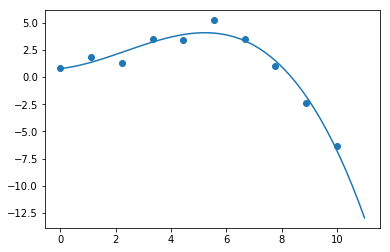

In [16]:
import scipy as sp


x = np.linspace(0, 10, 10)
xs = np.linspace(0, 11, 50)
y = np.array([0.8, 1.8, 1.3, 3.5, 3.4, 5.2, 3.5, 1.0, -2.4, -6.3])
spline = sp.interpolate.UnivariateSpline(x, y)
plt.scatter(x,y)
plt.plot(xs, spline(xs))
plt.show()

#  Raw To Image Project

Author: xueqin.chen


## Implement a basic image processing pipeline

Requirements:

Input: It is a RAW image that was captured with a Canon EOS T3 Rebel camera. Input data located in ./data/banana slug.tiff

Output: A traditional image which can be normally display in PC.

### Initials


In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

rawImg = cv2.imread('../data/banana_slug.tiff', cv2.IMREAD_ANYDEPTH)

height, width = rawImg.shape
channels = 1
print('Image height:' + str(height) +  ', width:' + str(width) + ', channels:' + str(channels))
print('Image has ' + str(rawImg.size) + ' size with ' + str(rawImg.dtype) + ' type')
print(('The image has ' + str(rawImg.itemsize * 8)) + ' bits per integer')
rawImgDouble = np.double(rawImg)

# plt.axis("off")
## opencv use BGR
## plt use RGB
# plt.imshow(rawImg)
# plt.show()



Image height:2856, width:4290, channels:1
Image has 12252240 size with uint16 type
The image has 16 bits per integer


### Linearization

1. All pixels with a value lower than 2047 correspond to pixels that would be black. 

2. All pixels with a value above 15000 are over-exposed pixels.

3. normalized all pixels to 0-1

In [22]:
rawImgDouble = np.minimum(15000, rawImgDouble)
rawImgDouble = np.maximum(2047, rawImgDouble)

minVal, maxVal, minIndex, maxIndex = cv2.minMaxLoc(rawImgDouble)
print("min:" + str(minVal) + " max:" + str(maxVal))

rawImgNorm = np.zeros((height, width))
ret = cv2.normalize(rawImgDouble, rawImgNorm, 1.0, 0, cv2.NORM_MINMAX)

min:2047.0 max:15000.0


### Identifying the correct Bayer pattern

Choose which pattern is the right Bayer pattern:
1. ’grbg’
2. ’rggb’
3. ’bggr’
4. ’gbrg’

In [24]:
## for identify bayer pattern
## get uchar image
rawImgUchar = np.zeros((height, width))
ret = cv2.normalize(rawImgDouble, rawImgUchar, 255, 0, cv2.NORM_MINMAX)

for i in range(0, 4):
    rowV=''
    for j in range(0,4):
        rowV += '(%d, %d)=%d  '%(i, j, rawImgUchar[i,j])
    print(rowV)

imgG = np.zeros((height, width>>1), dtype=rawImgNorm.dtype)
imgR = rawImgUchar[::2,::2] # red pixels
imgG[0::2,:] = rawImgUchar[::2,1::2] # green pixels
imgG[1::2,:] = rawImgUchar[1::2,::2] # green pixels
imgB = rawImgUchar[1::2,1::2] # blue pixels

# imgR = rawImgUchar[::2,1::2] # red pixels
# imgG[0::2,:] = rawImgUchar[::2,::2] # green pixels
# imgG[1::2,:] = rawImgUchar[1::2,1::2] # green pixels
# imgB = rawImgUchar[1::2,0::2] # blue pixels

cv2.imwrite('../data/imgR.jpg', imgR)
cv2.imwrite('../data/imgG.jpg', imgG)
cv2.imwrite('../data/imgB.jpg', imgB)


## Get normalize double image
imgG = np.zeros((height, width>>1), dtype=rawImgNorm.dtype)
imgR = rawImgNorm[::2,::2] # red pixels
imgG[0::2,:] = rawImgNorm[::2,1::2] # green pixels
imgG[1::2,:] = rawImgNorm[1::2,::2] # green pixels
imgB = rawImgNorm[1::2,1::2] # blue pixels


# imgR = rawImgNorm[::2,1::2] # red pixels
# imgG[0::2,:] = rawImgNorm[::2,::2] # green pixels
# imgG[1::2,:] = rawImgNorm[1::2,1::2] # green pixels
# imgB = rawImgNorm[1::2,0::2] # blue pixels

(0, 0)=3  (0, 1)=6  (0, 2)=3  (0, 3)=8  
(1, 0)=7  (1, 1)=3  (1, 2)=8  (1, 3)=3  
(2, 0)=3  (2, 1)=7  (2, 2)=3  (2, 3)=8  
(3, 0)=7  (3, 1)=3  (3, 2)=7  (3, 3)=3  


### White balancing
Implement both white world and gray world automatic white balancing algorithms

In [25]:
## gray  world
mean_r = cv2.mean(imgR)
mean_g = cv2.mean(imgG)
mean_b = cv2.mean(imgB)
# mean_gray = (mean_r[0] + mean_g[0] + mean_b[0])/3
# white_r = mean_gray/mean_r[0] * imgR
# white_g = mean_gray/mean_g[0] * imgG
# white_b = mean_gray/mean_b[0] * imgB

white_r = mean_g[0]/mean_r[0] * imgR
white_g = imgG
white_b = mean_g[0]/mean_b[0] * imgB

## white  world
max_r = np.max(imgR)
max_g = np.max(imgG)
max_b = np.max(imgB)

white_r2 = max_g/max_r * imgR
white_g2 = imgG
white_b2 = max_g/max_b * imgB

print("r: mean:" + str(mean_r[0]) + " max:"+ str(max_r) + " min:" + str(np.min(imgR)))
print("g: mean:" + str(mean_g[0]) + " max:"+ str(max_g) + " min:" + str(np.min(imgG)))
print("b: mean:" + str(mean_b[0]) + " max:"+ str(max_b) + " min:" + str(np.min(imgB)))

print("white r max:"+ str(np.max(white_r)) + " min:" + str(np.min(white_r)))
print("white g max:"+ str(np.max(white_g)) + " min:" + str(np.min(white_g)))
print("white b max:"+ str(np.max(white_b)) + " min:" + str(np.min(white_b)))


r: mean:0.031746930858 max:0.37921716976762143 min:0.0
g: mean:0.0581069658666 max:1.0000000000000002 min:0.0
b: mean:0.0332868023435 max:0.6553694124913148 min:0.0
white r max:0.694087854926488 min:0.0
white g max:1.0000000000000002 min:0.0
white b max:1.1440428458304757 min:0.0


### Demosaicing
Use bilinear interpolation for demosaicking

r max:10813 min:0
g max:14455 min:0
b max:16383 min:0
r max:168 min:0
g max:225 min:0
b max:255 min:0


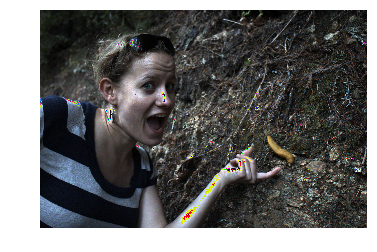

In [31]:
large_imgR = cv2.resize(white_r, (width, height), cv2.INTER_LINEAR)
large_imgG = cv2.resize(white_g, (width, height), cv2.INTER_LINEAR)
large_imgB = cv2.resize(white_b, (width, height), cv2.INTER_LINEAR)

color_image = np.zeros(rawImgNorm.shape + (3,))
color_image[:,:,0] = large_imgR
color_image[:,:,1] = large_imgG
color_image[:,:,2] = large_imgB

## 2's 14 -1
ret = cv2.normalize(color_image, color_image, 16383, 0, cv2.NORM_MINMAX)
color_image = np.uint16(color_image)

print("r max:"+ str(np.max(color_image[:,:,0])) + " min:" + str(np.min(color_image[:,:,0])))
print("g max:"+ str(np.max(color_image[:,:,1])) + " min:" + str(np.min(color_image[:,:,1])))
print("b max:"+ str(np.max(color_image[:,:,2])) + " min:" + str(np.min(color_image[:,:,2])))


## Check result
res_temp = np.zeros(color_image.shape, dtype=np.uint16)
ret = cv2.normalize(color_image, res_temp, 255, 0, cv2.NORM_MINMAX)
res_temp = np.uint8(res_temp)
print("r max:"+ str(np.max(res_temp[:,:,0])) + " min:" + str(np.min(res_temp[:,:,0])))
print("g max:"+ str(np.max(res_temp[:,:,1])) + " min:" + str(np.min(res_temp[:,:,1])))
print("b max:"+ str(np.max(res_temp[:,:,2])) + " min:" + str(np.min(res_temp[:,:,2])))
# cv2.imwrite('../data/out_temp.jpg', res_temp * 5)
plt.axis("off");plt.imshow(res_temp * 4);plt.show()

### Brightness adjustment and gamma correction

Cnon-linear = 12.92 · Clinear, Clinear < 0.0031308

Cnon-linear = (1 + 0.055) · C((1)/2.4) (linear) − 0.055, Clinear >= 0.0031308



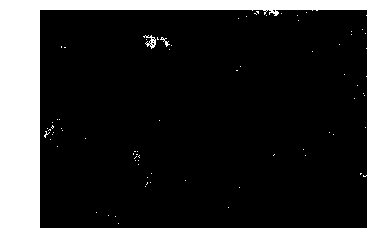

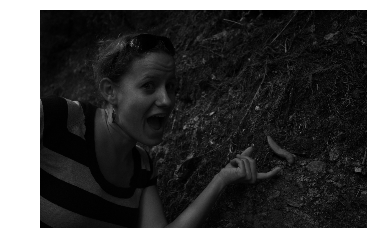

In [42]:
t1 = large_imgR <= 0.003
t2 = large_imgR > 0.003
gamma_r = cv2.bitwise_and(large_imgR, np.double(t1))


ret = cv2.normalize(gamma_r, gamma_r, 255, 0, cv2.NORM_MINMAX)
gamma_r = np.uint8(gamma_r)


plt.axis("off");plt.imshow(t1 * 255, cmap=plt.cm.gray);plt.show()
plt.axis("off");plt.imshow(gamma_r, cmap=plt.cm.gray);plt.show()

In [ ]:
dpi = 72.0
figsize = height / float(dpi), width / float(dpi)
fig = plt.figure(figsize=figsize, dpi=72.0)
# plt.subplot(111), plt.title("G"), plt.imshow(rawG), plt.axis("off")
# plt.show()